In [1]:
import pathlib
from pathlib import Path
import os
import numpy as np
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following line uses the absolute path directory to read in where the training photos are saved, remember to put an 'r' in front for non-linux devices.

In [0]:
train = Path('/content/drive/My Drive/Colab Notebooks/binary_train')
test = Path('/content/drive/My Drive/Colab Notebooks/binary_test')

train_count = len(list(train.glob('*/*.jpg')))
test_count = len(list(test.glob('*/*.jpg')))

In [4]:
train_count
#test_count

418

In [0]:
CLASS_NAMES = np.array([item.name for item in train.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES = list(CLASS_NAMES)
if CLASS_NAMES[0] == 'images':
    CLASS_BINARY = ['1','0']
else:
    CLASS_BINARY = ['0','1']

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 648
IMG_WIDTH = 864
INPUT_HEIGHT = 24
INPUT_WIDTH = 32

STEPS_PER_EPOCH = np.ceil(train_count/BATCH_SIZE)

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     class_mode='binary',
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),
                                                     class_mode='binary',
                                                       )




Found 418 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


In [8]:
train_generator.class_indices

{'default': 0, 'images': 1}

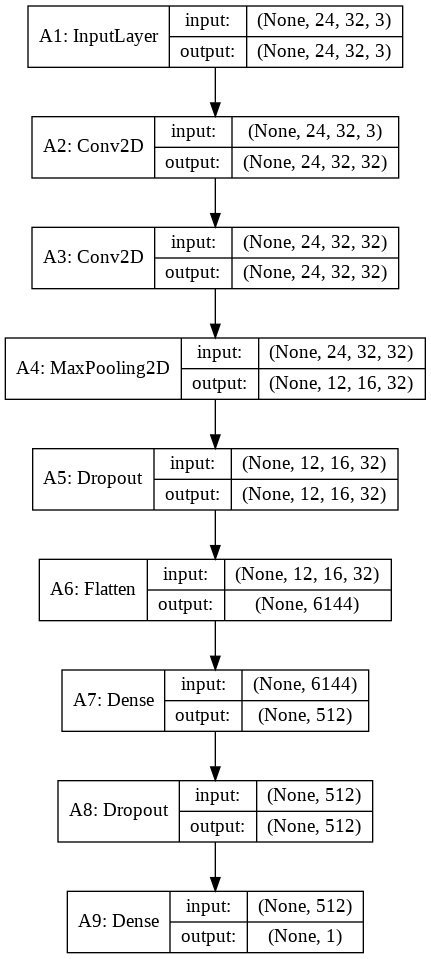

In [39]:
A1 = Input(shape=(INPUT_HEIGHT,INPUT_WIDTH,3),name='A1')
A2 = Conv2D(32, (3, 4), 
                 activation='relu', 
                 padding='same', 
                 name='A2')(A1)
A3 = Conv2D(32, (3, 4), activation='relu', padding='same',name='A3')(A2)
A4 = MaxPooling2D(pool_size=(2, 2),name='A4')(A3)
A5 = Dropout(0.25,name='A5')(A4)
A6 = Flatten(name='A6')(A5)
A7 = Dense(512, activation='relu',name='A7')(A6)
A8 = Dropout(0.5,name='A8')(A7)
A9 = Dense(1, activation='hard_sigmoid',name='A9')(A8)

model = Model(inputs=[A1],outputs=[A9])
plot_model(model,show_shapes=True)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A1 (InputLayer)              (None, 24, 32, 3)         0         
_________________________________________________________________
A2 (Conv2D)                  (None, 24, 32, 32)        1184      
_________________________________________________________________
A3 (Conv2D)                  (None, 24, 32, 32)        12320     
_________________________________________________________________
A4 (MaxPooling2D)            (None, 12, 16, 32)        0         
_________________________________________________________________
A5 (Dropout)                 (None, 12, 16, 32)        0         
_________________________________________________________________
A6 (Flatten)                 (None, 6144)              0         
_________________________________________________________________
A7 (Dense)                   (None, 512)               3146

In [0]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
hist = model.fit_generator(
        train_generator,
        class_weight = {0: 15.,
                1: 1.},
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/50
14/14 [==============================] - 7s 473ms/step - loss: 0.6390 - acc: 0.3273 - val_loss: 0.2304 - val_acc: 0.4800
Epoch 2/50
14/14 [==============================] - 7s 481ms/step - loss: 0.3051 - acc: 0.6636 - val_loss: 0.0966 - val_acc: 0.8571
Epoch 3/50
14/14 [==============================] - 6s 433ms/step - loss: 0.1177 - acc: 0.9036 - val_loss: 5.4324e-04 - val_acc: 1.0000
Epoch 4/50
14/14 [==============================] - 6s 451ms/step - loss: 0.0661 - acc: 0.9507 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 5/50
14/14 [==============================] - 6s 431ms/step - loss: 0.0701 - acc: 0.9551 - val_loss: 0.0310 - val_acc: 0.9388
Epoch 6/50
14/14 [==============================] - 6s 447ms/step - loss: 0.0577 - acc: 0.9551 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/50
14/14 [==============================] - 6s 454ms/step - loss: 0.0187 - acc: 0.9955 - val_loss: 2.7045e-05 - val_acc: 1.0000
Epoch 8/50
14/14 [==============================] - 6s 452ms/ste

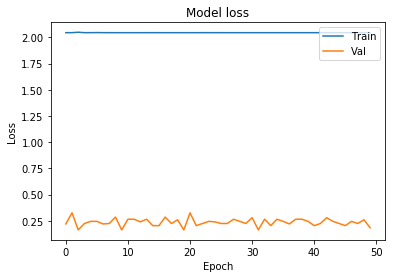

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [36]:
model.evaluate(x=validation_generator)[1]

6/6 [==============================] - 1s 103ms/step


0.7627118633965314

In [0]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (24, 32, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/drive/My Drive/Colab Notebooks/binary_train/images/0_left_cutbottom.jpg')
results = model.predict(image)

In [38]:
results



array([[1.]], dtype=float32)

In [0]:
#freeze model
A1.trainable = False
A2.trainable = False
A3.trainable = False
A4.trainable = False
A5.trainable = False
A6.trainable = False
A7.trainable = False
A8.trainable = False
A9.trainable = False

In [18]:
train = Path('/content/drive/My Drive/Colab Notebooks/colours_train')
test = Path('/content/drive/My Drive/Colab Notebooks/colours_test')


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=str(train),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH)
                                                   )


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(directory=str(test),
                                                     batch_size=int(BATCH_SIZE/3),
                                                     shuffle=True,
                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH)
                                                       )




'\ntrain_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)\n\ntrain_generator = train_datagen.flow_from_directory(directory=str(train),\n                                                     batch_size=BATCH_SIZE,\n                                                     shuffle=True,\n                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),\n                                                     classes = list(CLASS_NAMES))\n\n\ntest_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)\n\nvalidation_generator = test_datagen.flow_from_directory(directory=str(test),\n                                                     batch_size=int(BATCH_SIZE/3),\n                                                     shuffle=True,\n                                                     target_size=(INPUT_HEIGHT, INPUT_WIDTH),\n                                                     classes = list(CLASS_NAMES))\n\n\n'

In [10]:
B1 = Conv2D(32, (3, 4), activation='relu', padding='same',name='B1')(A5)
B2 = Conv2D(32, (3, 4), activation='relu', padding='same',name='B2')(B1)
B3 = MaxPooling2D(pool_size=(2, 2),name='B3')(B2)
B4 = Dropout(0.25,name='B4')(B3)
B5 = Flatten(name='B5')(B4)
B6 = Dense(512, activation='relu',name='B6')(B5)
B7 = Dropout(0.5,name='B7')(B6)
B8 = Dense(5, activation='softmax',name='B8')(B7)
 
model = Model(inputs=[A1],outputs=[B8])
plot_model(model,show_shapes=True)


"\nmodel = Sequential()\n\nmodel.add(Conv2D(32, (3, 4), \n                 activation='relu', \n                 padding='same', \n                 input_shape=(INPUT_HEIGHT,INPUT_WIDTH,3)))\nmodel.add(Conv2D(32, (3, 4), activation='relu', padding='same'))\n\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Conv2D(64, (3, 4), activation='relu', padding='same'))\nmodel.add(Conv2D(64, (3, 4), activation='relu', padding='same'))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(512, activation='relu'))\nmodel.add(Dropout(0.5))\n\nmodel.add(Dense(16, activation='softmax'))\n"

In [0]:
"""
model.add(Conv2D(32, (3, 4), 
                 activation='relu', 
                 padding='same', 
                 input_shape=(INPUT_HEIGHT,INPUT_WIDTH,3)))
model.add(Conv2D(32, (3, 4), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 4), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
"""

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
hist = model.fit_generator(
        train_generator,
        class_weight = {0: 15.,
                1: 1.},
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=5)

In [0]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [0]:
image = load('/content/drive/My Drive/Colab Notebooks/colours_test/white/11_middle.jpg')
results = model.predict(image)

In [0]:
results


In [0]:
#freeze model
B1.trainable = False
B2.trainable = False
B3.trainable = False
B4.trainable = False
B5.trainable = False
B6.trainable = False
B7.trainable = False
B8.trainable = False

In [0]:
#model.save('/content/drive/My Drive/Colab Notebooks/mymodel2.h5')

From this point onwards, refer to https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata under "load using tf.data" to be able to load the dataset in keras. 